In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
import music21
from fastai.text import *
import glob
import os
from tqdm import tqdm
from IPython.display import Image, Audio
import re

In [3]:
from midi_data import *

In [4]:
path = Path('../data/midi')

In [5]:
directories = [x for x in path.iterdir() if x.is_dir()]; directories

[PosixPath('../data/midi/cprato_midi'),
 PosixPath('../data/midi/Wikifonia'),
 PosixPath('../data/midi/transposed'),
 PosixPath('../data/midi/hymn'),
 PosixPath('../data/midi/classic_piano_scrape'),
 PosixPath('../data/midi/touhou_scrape'),
 PosixPath('../data/midi/hooktheory'),
 PosixPath('../data/midi/ecomp_midi'),
 PosixPath('../data/midi/freemidi_scrape'),
 PosixPath('../data/midi/piano_e_competition'),
 PosixPath('../data/midi/midiworld_scrape')]

In [6]:
hook_path = path/'hooktheory'
hook_info_path = hook_path/'key2info.json'
hook_metapath = hook_path/'song_metadata.json'

In [7]:
metadata = load_json(hook_metapath)

### Encoding music21 stream to text representation

In [8]:
song_info = list(metadata.values())[800]; song_info

{'artist': 'jam-project',
 'section': 'pre-chorus',
 'original_path': '../data/midi/hooktheory/pianoroll/j/jam-project/victory/pre-chorus_key.mid',
 'parts': ['verse', 'pre-chorus', 'chorus'],
 'song_url': 'https://www.hooktheory.com/theorytab/view/jam-project/victory',
 'genres': ['J-Pop', 'Video Game'],
 'midi_title': 'victory 2',
 'ht_bpm': '164',
 'ht_mode': '6',
 'ht_key': 'D',
 'ht_time_signature': '4',
 'instruments': ['Piano', 'Piano'],
 'bpm': 164.0,
 'inferred_key': 'C major',
 'seconds': 37.68292682926829,
 'time_signature': '4/4',
 'inferred_keyc': 'C major',
 'midi_keyc': '../data/midi/transposed/hooktheory/pianoroll/j/jam-project/victory/pre-chorus_key.mid'}

In [9]:
stream = file2stream(song_info['midi_keyc'])

In [10]:
# assuming 4/4 time
def stream_to_numpy(s, note_range=127, sample_freq=4):
    # FYI: midi middle C value=60
    maxTimeStep = int(s.duration.quarterLength * sample_freq)+1
    
    # (AS) TODO: need to order by instruments most played and filter out percussion or include the channel
    inst2idx = {inst.id:idx for idx,inst in enumerate(s.flat.getInstruments())}
    score_arr = np.zeros((maxTimeStep, len(inst2idx), note_range))

    notes=[]
    noteFilter=music21.stream.filters.ClassFilter('Note')
    chordFilter=music21.stream.filters.ClassFilter('Chord')
    
    def note_data(pitch, note):
        inst_id = note.activeSite.getInstrument().id
        iidx = inst2idx[inst_id]
        return (pitch.midi, round(note.offset*sample_freq), round(note.duration.quarterLength*sample_freq), iidx)

    for n in s.recurse().addFilter(noteFilter):
        notes.append(note_data(n.pitch, n))
        
    for c in s.recurse().addFilter(chordFilter):
        pitchesInChord=c.pitches
        for p in pitchesInChord:
            notes.append(note_data(p, c))

    for n in notes:
        if n is None: continue
        pitch,offset,duration,inst = n
        score_arr[offset, inst, pitch] = VALTSTART                 # Strike note
        score_arr[offset+1:offset+duration, inst, pitch] = VALTCONT      # Continue holding note
    return score_arr

In [11]:
VALTSTART = 1
VALTCONT = 2
NOTE_SEP = ':'
SEP = '||'
MSTART = '|s|'
MEND = '|e|'
NPRE = 'n'
OPRE = 'o'
TPRE = 't'
TSTART = f'{TPRE}{VALTSTART}'
TCONT = f'{TPRE}{VALTCONT}'
IPRE = 'i'

In [12]:
RENOTE = re.compile('[A-Z][#-b]?\d')
class NoteEnc():
    # tie = note start/continue, note = midi value, inst = instrument
    def __init__(self, note, tie, inst=None):
        assert(tie > 0)
        self.note,self.tie,self.inst = note,int(tie),str(inst)
        self.pitch = music21.pitch.Pitch(self.note)
        
    def long_comp(self):
        nname = NPRE + self.pitch.name
        oname = OPRE + str(self.pitch.octave)
        tname = TSTART if self.tie == VALTSTART else TCONT # ts=note start, tc=note continue
        iname = IPRE+self.inst
        return [nname,oname,tname,iname]
        
    def long_repr(self):
        # returns something like 'nG:o2:ts:i1'
        return NOTE_SEP.join(self.long_comp())
    
    def __repr__(self):
        kname = self.pitch.nameWithOctave
        tname = TSTART if self.tie == VALTSTART else TCONT # ts=note start, tc=note continue
        return kname+tname
    
    def ival(self): # instrument number value
        return int(self.inst or 0)
    
    def m21_note(self):
        return music21.note.Note(self.note)
        
    @classmethod
    def parse_arr(self, arr):
        kv = {s[0]:s[1:] for s in arr if s}
        if NPRE not in kv: return None
        note = kv[NPRE]
        if OPRE in kv: note += kv[OPRE]
        tie = int(kv[TPRE])
        assert(re.fullmatch(RENOTE, note))
        return NoteEnc(note=note, tie=tie, inst=kv.get(IPRE))

In [14]:
def timestep2seq(timestep):
    # int x pitch
    notes = [NoteEnc(n,timestep[i,n],i) for i,n in zip(*timestep.nonzero())]
    sorted_keys = [n for n in sorted(notes, key=lambda x: x.pitch)]
    return sorted_keys

In [15]:
s_arr = stream_to_numpy(stream)

In [16]:
s_arr.sum()

3597.0

In [18]:
def chordarr2seq(score_arr):
    # note x instrument x pitch
    # 1 = strike, 2 = continue
    return [timestep2seq(t) for t in score_arr]    

In [19]:
seq = chordarr2seq(s_arr)

In [20]:
def seq2str(seq):
    result = []
    for idx,timestep in enumerate(seq):
        if idx and idx%4 == 0:
            result.append(MEND)
        if idx and idx < len(seq)-1:
            result.append(MSTART)
        flat_time = [i for n in timestep for i in n.long_comp()]
        result.extend(flat_time)
        result.append(SEP)
    return ' '.join(result)
        
        
    

In [21]:
seq_str = seq2str(seq)

In [ ]:
def midi2str(midi_file):
    stream = file2stream(midi_file)
    s_arr = stream_to_numpy(stream)
    seq = chordarr2seq(s_arr)
    return seq2str(seq)

### Decoding

In [22]:
def steps2notearr(tarr):
    idxs = [idx for idx,s in enumerate(tarr) if s and s[0] == NPRE]
    notes = []
    for a in np.split(tarr, idxs):
        try: 
            note = NoteEnc.parse_arr(a) 
            if note: notes.append(note)
        except Exception as e:
            print(e)
    return notes

In [23]:
def str2seq(seq_str):
    timesteps = seq_str.split(SEP)
    return [steps2notearr(t.split(' ')) for t in timesteps]
        

In [24]:
res = str2seq(seq_str)

In [27]:
def seq2numpy(seq, note_range=127):
    num_instruments = max([n.ival() for t in seq for n in t]) + 1
    score_arr = np.zeros((len(seq), num_instruments, note_range))
    for idx,ts in enumerate(seq):
        for note in ts:
            score_arr[idx,note.ival(),note.pitch.midi] = note.tie
    return score_arr

In [28]:
np_arr = seq2numpy(res)

In [29]:
np_arr.sum()

3597.0

In [42]:
# from music21 import
def part2chords_seq_old(part, duration, inst=None):
    "Deprecated - 1 quarternote chord per timestep. Ties are used to connect notes"
    stream = music21.stream.Stream()
    stream.append(music21.instrument.Piano())
    stream.append(music21.meter.TimeSignature('4/4'))
    continues = (part == 2)[::-1].cumsum(axis=0)[::-1]
    for tidx,t in enumerate(part):
        note_idxs = t.nonzero()[0]
        if len(note_idxs) == 0: 
            stream.append(music21.note.Rest(duration=duration))
            continue
        notes = []
        for nidx in note_idxs:
            note = music21.note.Note(nidx)
            tval = part[tidx,nidx]
            tnext = part[tidx+1,nidx] if tidx+1 < len(part) else 0
            if tval == VALTSTART and tnext == VALTCONT: 
                note.tie = music21.tie.Tie('start') # start of long note
            if tval == VALTCONT:
                if tnext != VALTCONT: note.tie = music21.tie.Tie('stop') # note not continued at next time step
                else: note.tie = music21.tie.Tie('continue') # consecutive continues
            notes.append(note)
        chord = music21.chord.Chord(notes, duration=duration)#, offset=tidx*duration.quarterLength)
        stream.append(chord)
    return stream

In [35]:
def calc_durations(part):
    continues = (part == 2).astype(int)
    for i in reversed(range(continues.shape[0]-1)):
        continues[i] += continues[i+1]*continues[i]
    return continues
        
# from music21 import
def part2chords(part, duration, stream=None, inst=None):
    if stream is None: stream = music21.stream.Stream()
    stream.append(music21.instrument.Piano())
    stream.append(music21.meter.TimeSignature('4/4'))
    stream.append(music21.key.KeySignature(0))
    starts = part == 1
    continues = calc_durations(part)
    for tidx,t in enumerate(starts):
        note_idxs = t.nonzero()[0]
        if len(note_idxs) == 0: continue
        notes = []
        for nidx in note_idxs:
            note = music21.note.Note(nidx)
            tnext = continues[tidx+1,nidx] if tidx+1 < len(part) else 0
            note.duration = music21.duration.Duration((tnext+1)*duration.quarterLength)
            notes.append(note)
        chord = music21.chord.Chord(notes, offset=tidx*duration.quarterLength)
        stream.append(chord)
    return stream

In [36]:
def arr2stream(arr, sample_freq=4):
    duration = music21.duration.Duration(1. / sample_freq)
    stream = music21.stream.Stream()
    for inst in range(arr.shape[1]):
        p = part2chords(arr[:,inst,:], duration, stream=music21.stream.Part())
        stream.append(p)
    return stream

In [ ]:
def seq2stream()

In [37]:
s = arr2stream(np_arr)

In [34]:
stream.show('text')

{0.0} <music21.stream.Part 0x7ff42b0a8b38>
    {0.0} <music21.instrument.Piano Piano>
    {0.0} <music21.tempo.MetronomeMark Quarter=164.0>
    {0.0} <music21.key.Key of D major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.stream.Voice 0x7ff42b0b5ac8>
        {0.0} <music21.chord.Chord B3 D4>
        {0.5} <music21.chord.Chord B3 D4>
        {1.0} <music21.chord.Chord B3 D4>
        {1.5} <music21.chord.Chord B3 D4>
        {2.0} <music21.chord.Chord A3 D4>
        {2.5} <music21.chord.Chord A3 D4>
        {3.0} <music21.chord.Chord B3 D4>
        {3.5} <music21.chord.Chord A3 D4>
        {4.0} <music21.chord.Chord B3 E4>
        {5.0} <music21.chord.Chord G3 B3>
        {6.0} <music21.chord.Chord G3 B3>
        {7.0} <music21.chord.Chord G3 B3>
        {7.5} <music21.chord.Chord A3 C4>
        {8.0} <music21.chord.Chord B3 D4>
        {8.5} <music21.chord.Chord D4 G4>
        {10.0} <music21.chord.Chord B3 D4>
        {10.5} <music21.chord.Chord D4 G4>
        {12.0

In [38]:
s.show('text')

{0.0} <music21.stream.Part 0x7ff42bf0c6d8>
    {0.0} <music21.instrument.Piano Piano>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.key.KeySignature of no sharps or flats>
    {0.0} <music21.chord.Chord B3 D4>
    {0.5} <music21.chord.Chord B3 D4>
    {1.0} <music21.chord.Chord B3 D4>
    {1.5} <music21.chord.Chord B3 D4>
    {2.0} <music21.chord.Chord A3 D4>
    {2.5} <music21.chord.Chord A3 D4>
    {3.0} <music21.chord.Chord B3 D4>
    {3.5} <music21.chord.Chord A3 D4>
    {4.0} <music21.chord.Chord B3 E4>
    {5.0} <music21.chord.Chord G3 B3>
    {6.0} <music21.chord.Chord G3 B3>
    {7.0} <music21.chord.Chord G3 B3>
    {7.5} <music21.chord.Chord A3 C4>
    {8.0} <music21.chord.Chord B3 D4>
    {8.5} <music21.chord.Chord D4 G4>
    {10.0} <music21.chord.Chord B3 D4>
    {10.5} <music21.chord.Chord D4 G4>
    {12.0} <music21.chord.Chord B3 D4>
    {12.5} <music21.chord.Chord B3 D4>
    {13.0} <music21.chord.Chord B3 D4>
    {13.5} <music21.chord.Chord C4 E4>
    {14

In [ ]:
stream.show('midi')

In [ ]:
s.show('midi')

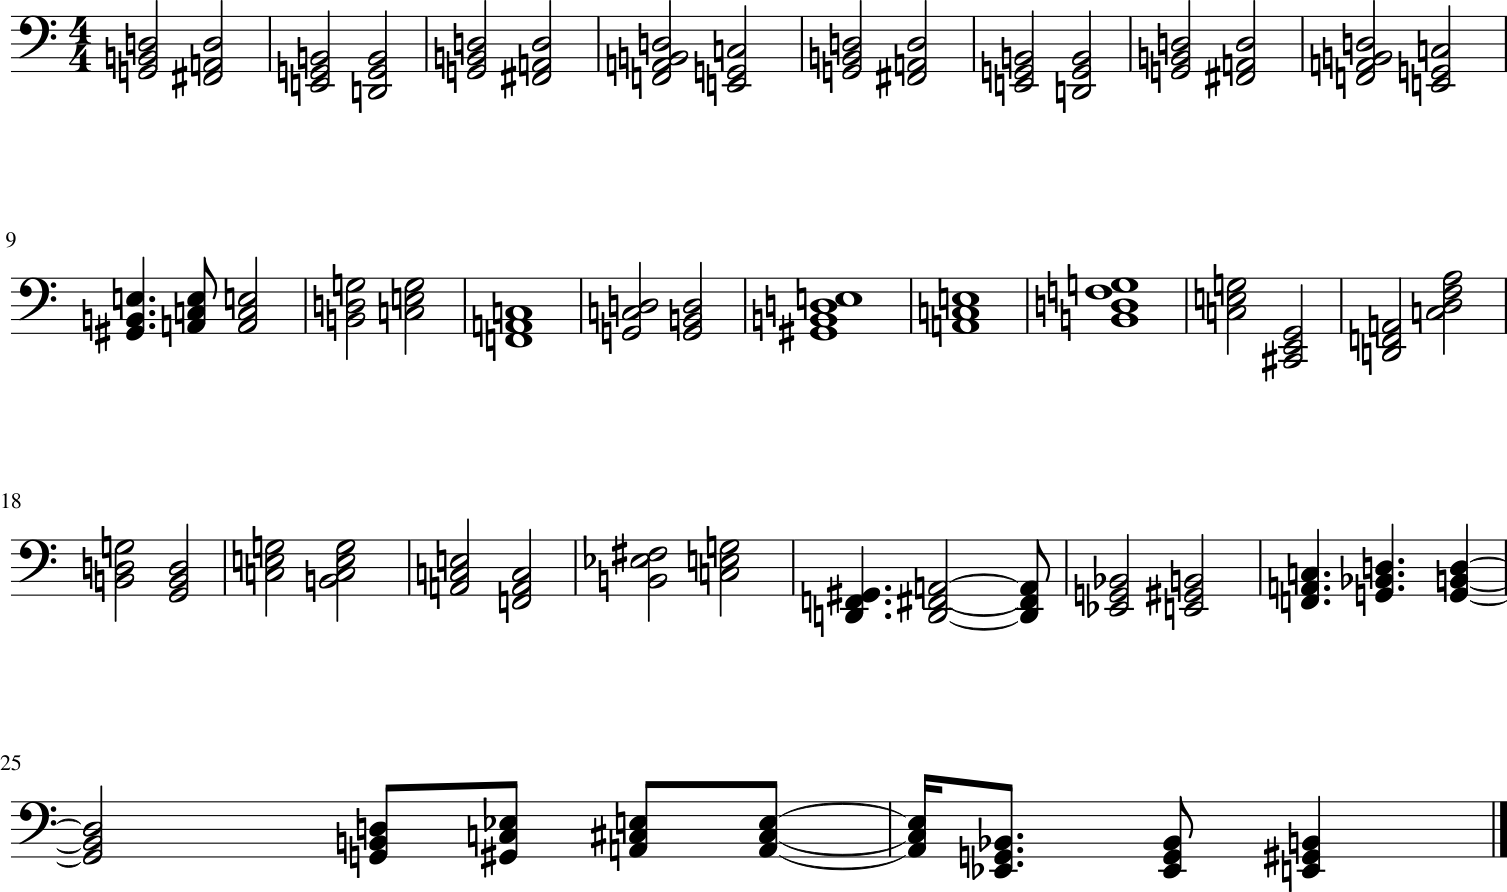

In [114]:
s[1].show()

In [89]:
continues[:, 50:70].mean()

0.13623188405797101

In [90]:
sample_freq=4
duration = music21.duration.Duration(1. / sample_freq)

In [91]:
stream_test = part2chords(p1, duration=duration)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
3
3
3
3
1
1
1
1
1
1
5
5
1
1
5
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
3
3
3
3
1
1
1
1
1
1
5
5
1
1
5
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
5
5
1
1
3
3
3
3
5
5
1
1
3
3
1
1
3
3
3
3
3
3
3
3
5
5
1
1
3
3
3
3
3
3
3
3
3
3
1
3
1
1
3
1
3
3
3
3
3
3
3
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
7
15
3
3
7
3
1
1
3
3
3
3
3
11
3
3
3
3
3
3
3
3
1
1
3
3
5
5
3
3
3
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
9
9


In [92]:
stream_test.show('text')

{0.0} <music21.instrument.Piano Piano>
{0.0} <music21.meter.TimeSignature 4/4>
{0.0} <music21.chord.Chord B3 D4>
{0.5} <music21.chord.Chord B3 D4>
{1.0} <music21.chord.Chord B3 D4>
{1.5} <music21.chord.Chord B3 D4>
{2.0} <music21.chord.Chord A3 D4>
{2.5} <music21.chord.Chord A3 D4>
{3.0} <music21.chord.Chord B3 D4>
{3.5} <music21.chord.Chord A3 D4>
{4.0} <music21.chord.Chord B3 E4>
{5.0} <music21.chord.Chord G3 B3>
{6.0} <music21.chord.Chord G3 B3>
{7.0} <music21.chord.Chord G3 B3>
{7.5} <music21.chord.Chord A3 C4>
{8.0} <music21.chord.Chord B3 D4>
{8.5} <music21.chord.Chord D4 G4>
{10.0} <music21.chord.Chord B3 D4>
{10.5} <music21.chord.Chord D4 G4>
{12.0} <music21.chord.Chord B3 D4>
{12.5} <music21.chord.Chord B3 D4>
{13.0} <music21.chord.Chord B3 D4>
{13.5} <music21.chord.Chord C4 E4>
{14.0} <music21.chord.Chord B3 D4>
{14.5} <music21.chord.Chord A3 C4>
{15.0} <music21.chord.Chord G3 B3>
{15.5} <music21.chord.Chord F#3 A3>
{16.0} <music21.chord.Chord B3 D4>
{16.5} <music21.chord.Cho

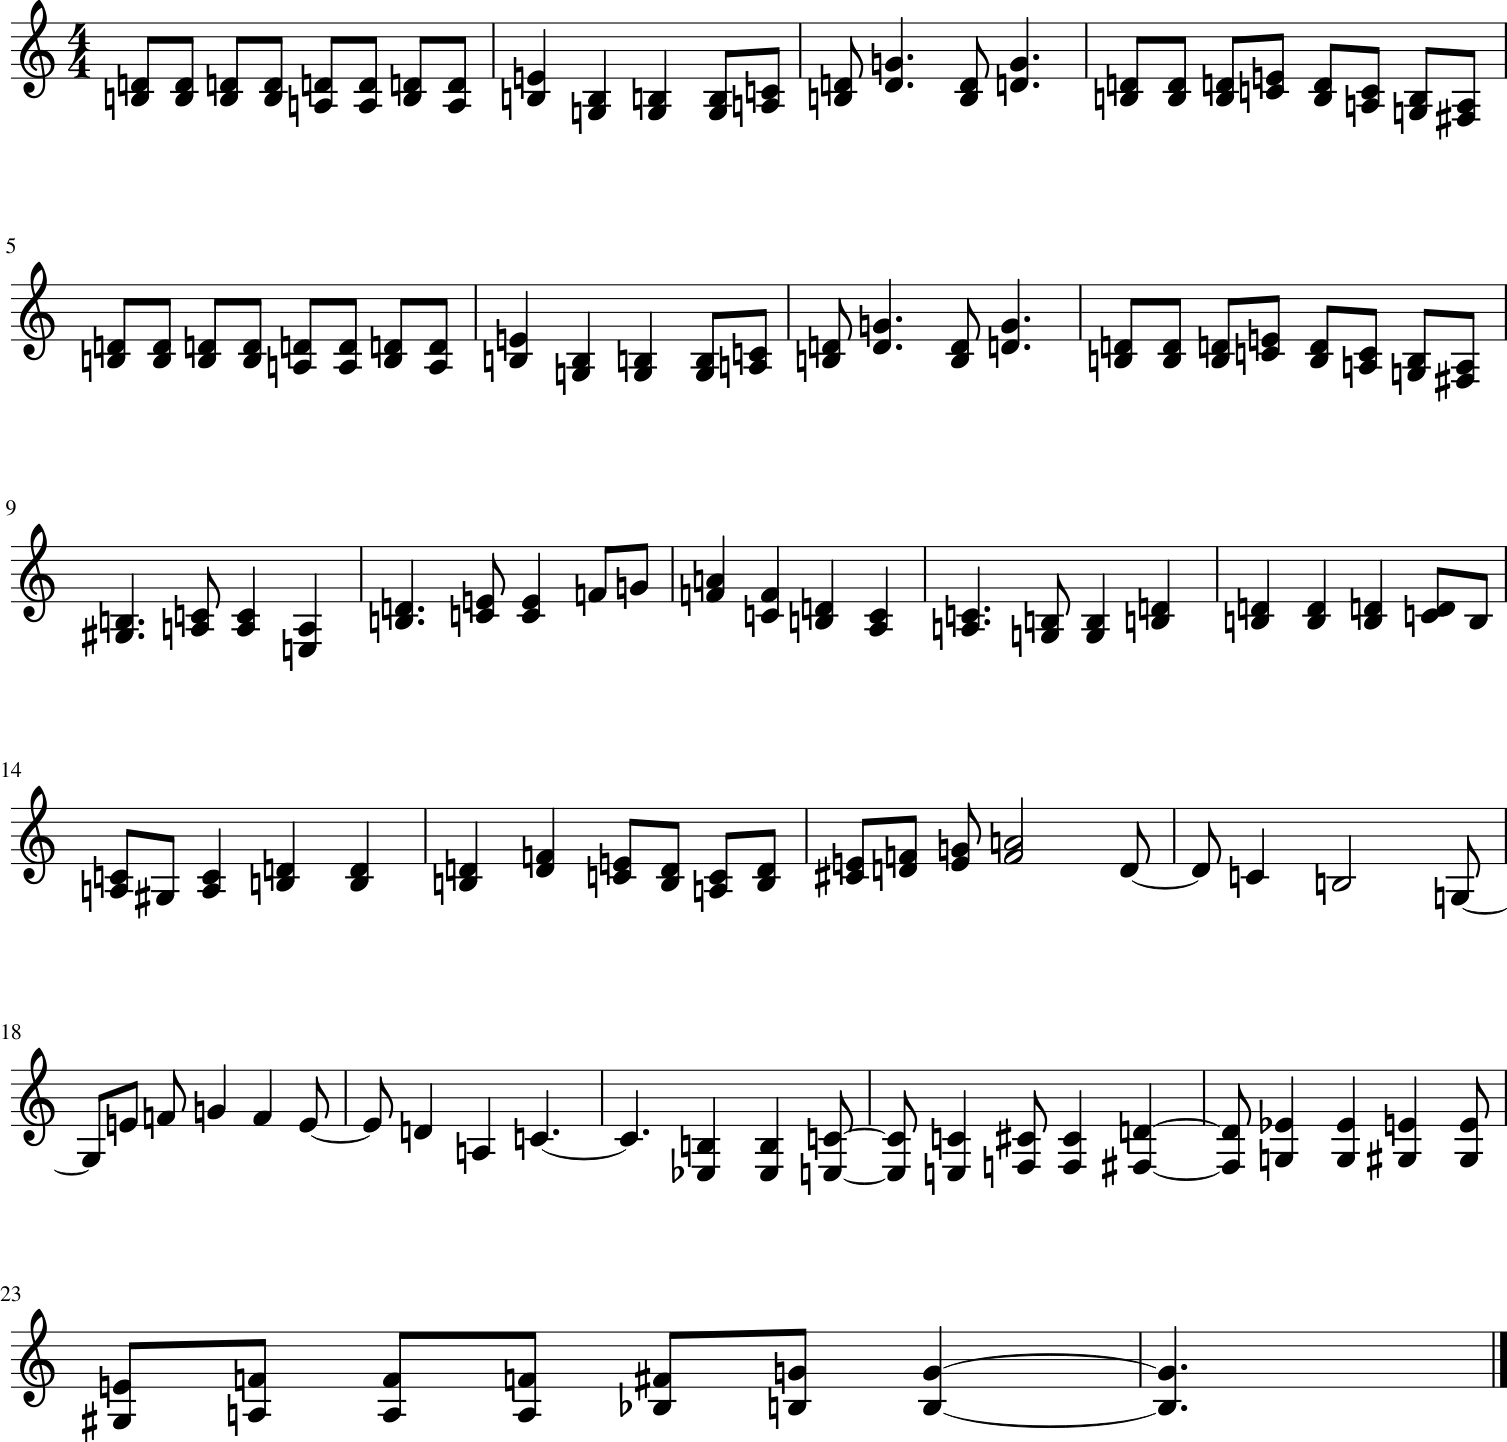

In [95]:
stream_test.show()

In [ ]:
stream_test.show('midi')

In [93]:
stream.show('text')

{0.0} <music21.stream.Part 0x7f949efe8da0>
    {0.0} <music21.instrument.Piano Piano>
    {0.0} <music21.tempo.MetronomeMark Quarter=164.0>
    {0.0} <music21.key.Key of D major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.stream.Voice 0x7f949ffc6d30>
        {0.0} <music21.chord.Chord B3 D4>
        {0.5} <music21.chord.Chord B3 D4>
        {1.0} <music21.chord.Chord B3 D4>
        {1.5} <music21.chord.Chord B3 D4>
        {2.0} <music21.chord.Chord A3 D4>
        {2.5} <music21.chord.Chord A3 D4>
        {3.0} <music21.chord.Chord B3 D4>
        {3.5} <music21.chord.Chord A3 D4>
        {4.0} <music21.chord.Chord B3 E4>
        {5.0} <music21.chord.Chord G3 B3>
        {6.0} <music21.chord.Chord G3 B3>
        {7.0} <music21.chord.Chord G3 B3>
        {7.5} <music21.chord.Chord A3 C4>
        {8.0} <music21.chord.Chord B3 D4>
        {8.5} <music21.chord.Chord D4 G4>
        {10.0} <music21.chord.Chord B3 D4>
        {10.5} <music21.chord.Chord D4 G4>
        {12.0

In [ ]:
stream.show('midi')

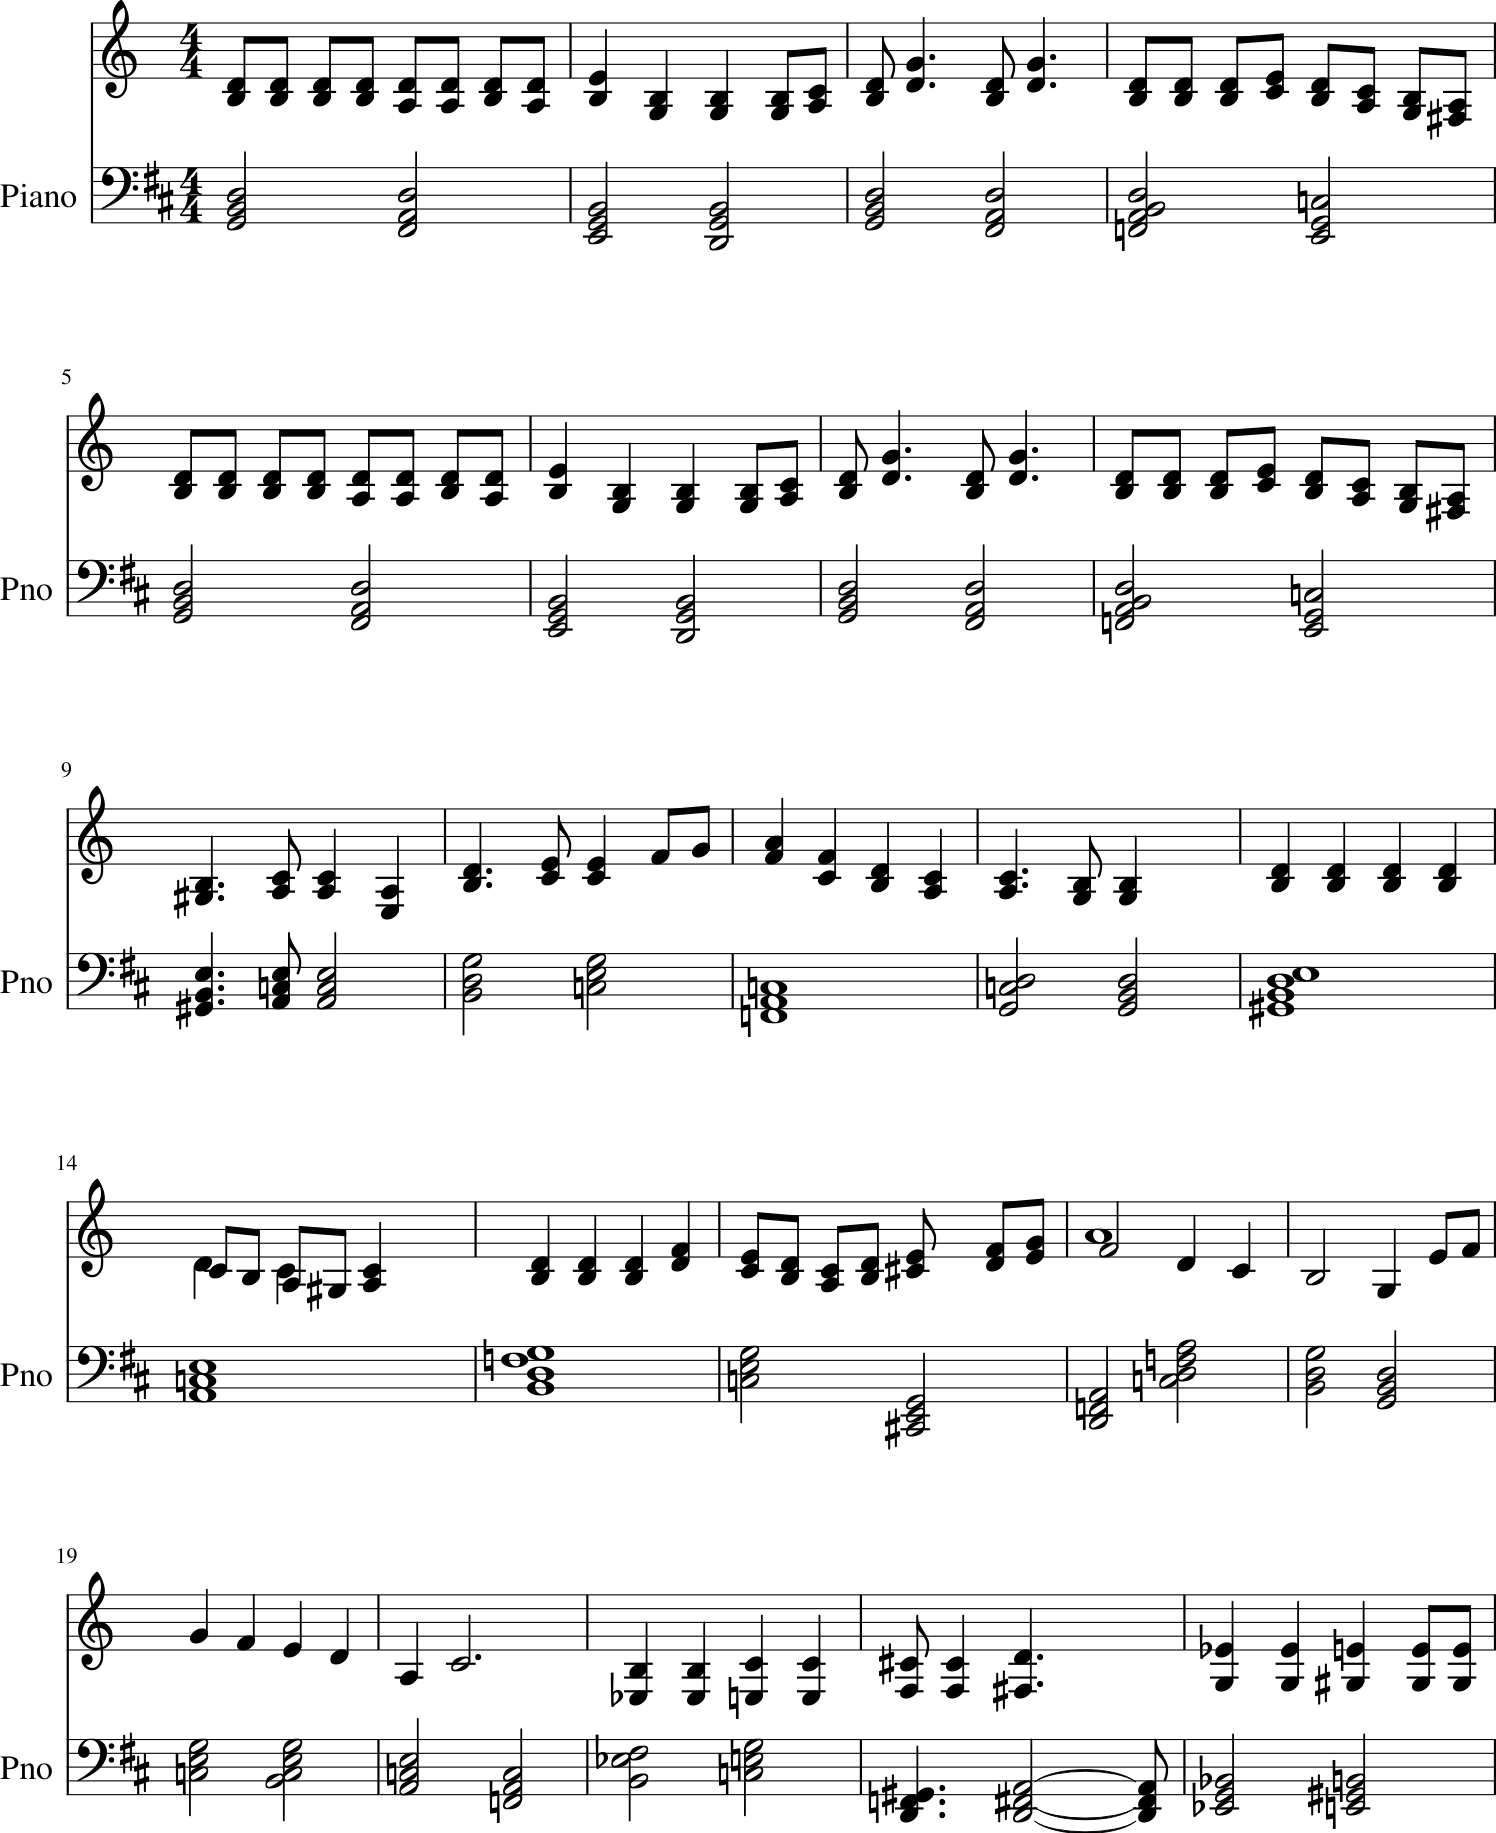

In [40]:
stream.show()

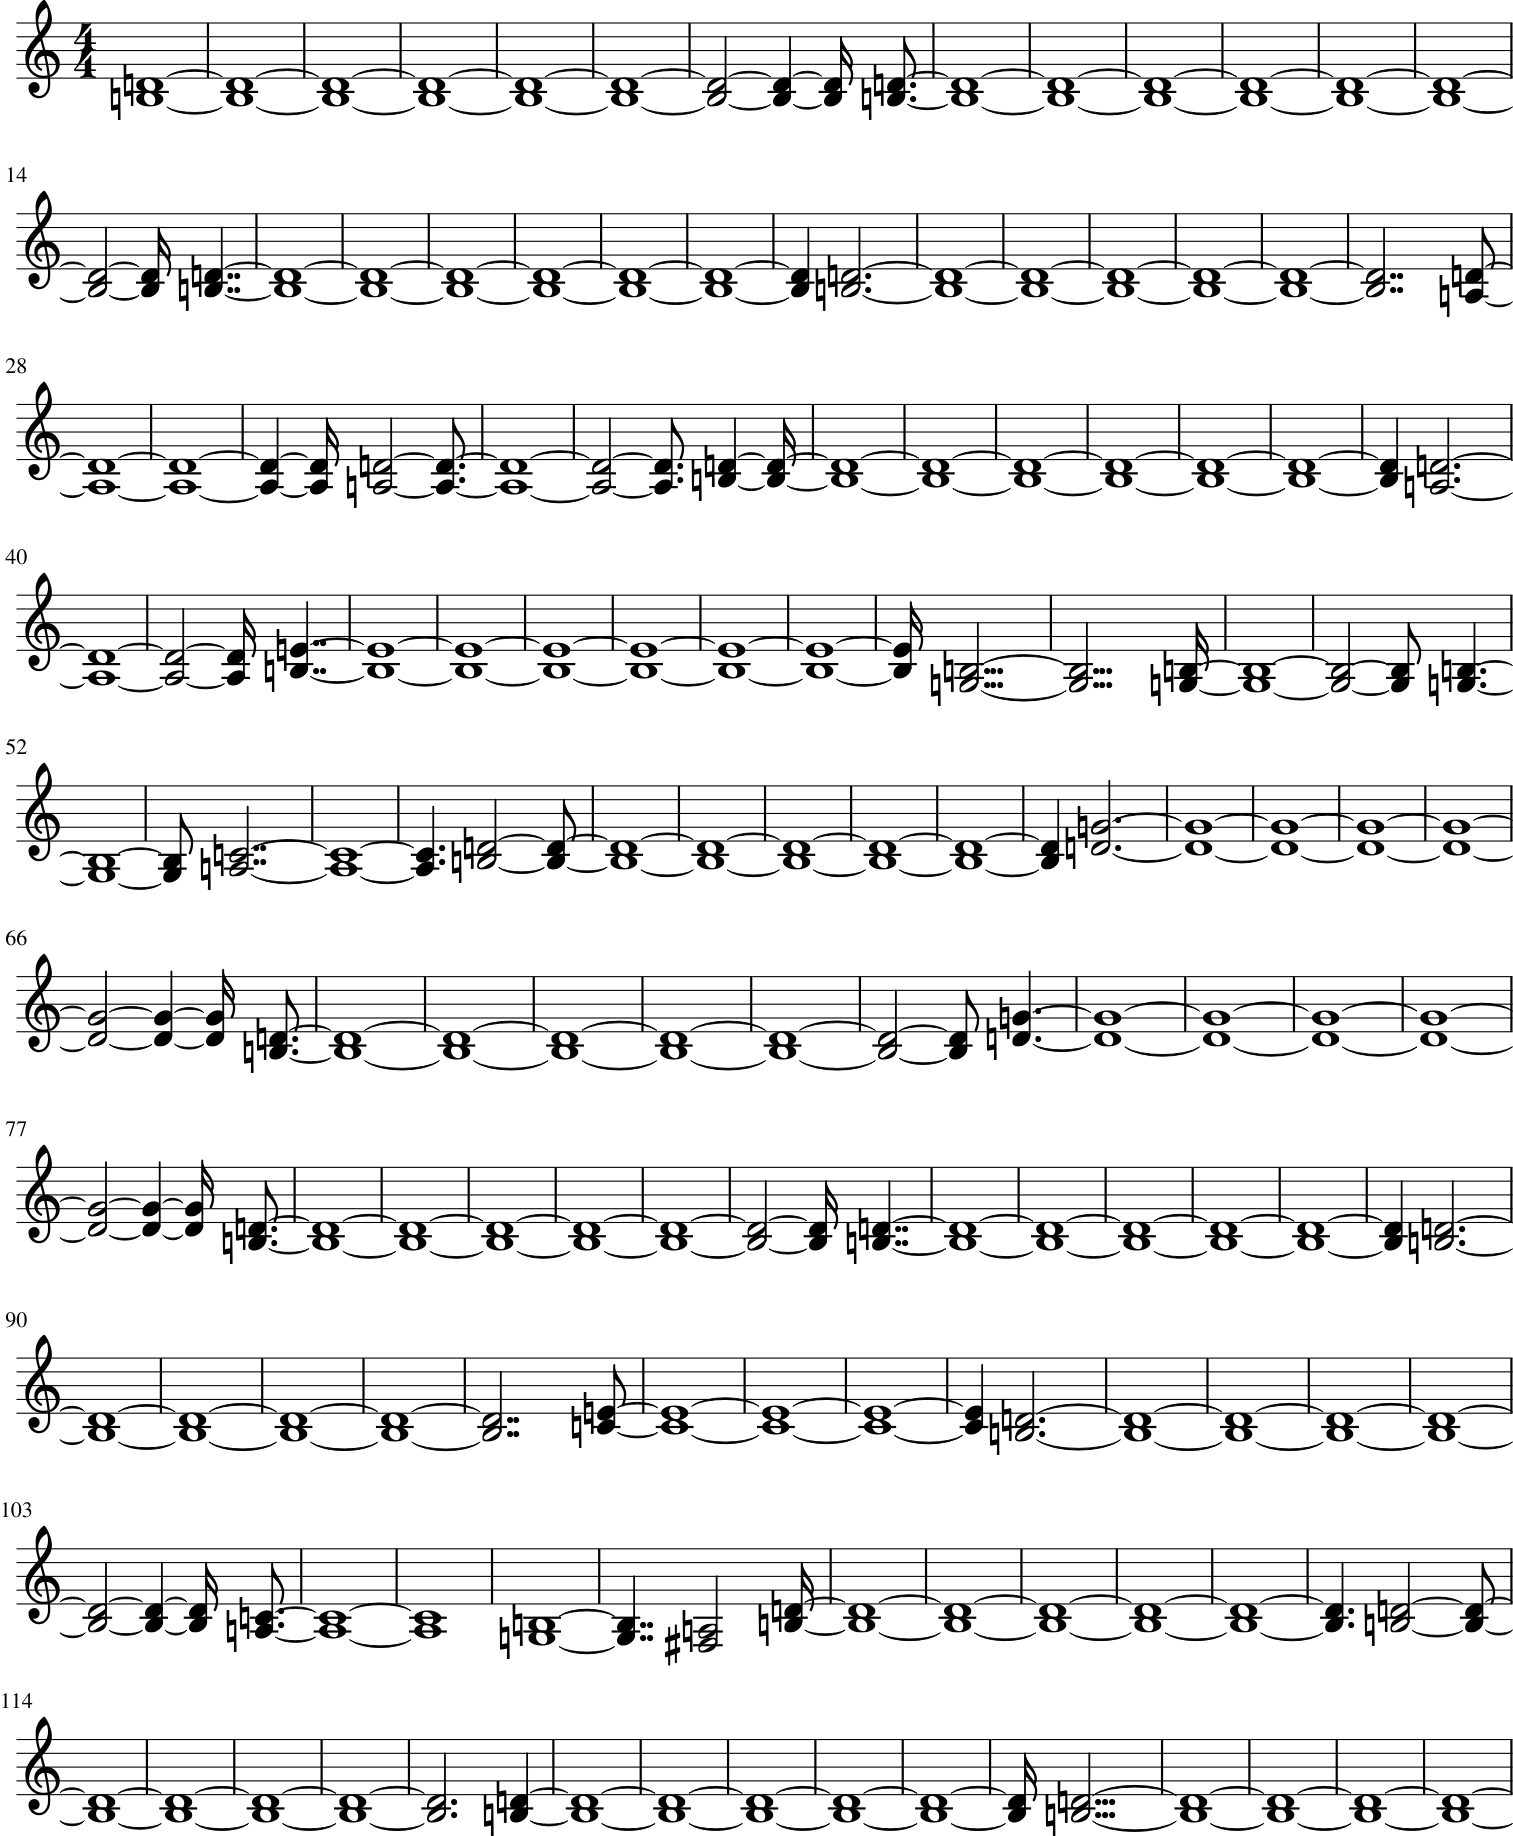

In [63]:
stream_test.show()

In [ ]:
stream_test.show('midi')